I started the cluster

    $ ipcluster start --n=6

In [1]:
import os
from ipyparallel import Client

In [2]:
rc = Client()
ar = rc[:]

with ar.sync_imports():
    import numpy
    import dust
    import sigma_scat

importing numpy on engine(s)
importing dust on engine(s)
importing sigma_scat on engine(s)


In [3]:
def calc_tau_scat( energy ):
    AMIN, AMAX = 0.005, 0.25 # microns
    NA  = 50  # number of points to use to sample distribution
    RHO = 3.8 # grain density (g cm^-3)
    P   = 3.5 # power law slope
    MDUST  = 1.e22 * dust.c.mp() * 0.009  # magic numbers (dust mass per 10^22 H)
    
    mrn  = dust.Dustdist( rad=numpy.linspace(AMIN,AMAX,NA), rho=RHO, p=P )
    kmod = sigma_scat.Kappascat( E=energy, dist=dust.Dustspectrum(rad=mrn), 
                           scatm=sigma_scat.makeScatmodel('Mie','Silicate') )
    return kmod.kappa * MDUST

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
ENERGY = np.logspace(-1,1,500)

In [6]:
%%time
base_result = ar.map(calc_tau_scat, ENERGY)

CPU times: user 9.09 ms, sys: 1.23 ms, total: 10.3 ms
Wall time: 10.1 ms


In [7]:
tau_scat = np.array([b[0] for b in base_result])

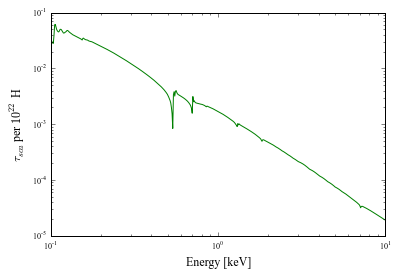

In [8]:
plt.plot( ENERGY, tau_scat, 'g-' )
plt.loglog()
plt.xlabel('Energy [keV]')
plt.ylabel(r'$\tau_{sca}$ per $10^{22}$ H')

### Now do extinction

In [9]:
def calc_tau_ext( energy ):
    AMIN, AMAX = 0.005, 0.25 # microns
    NA  = 50  # number of points to use to sample distribution
    RHO = 3.8 # grain density (g cm^-3)
    P   = 3.5 # power law slope
    MDUST  = 1.e22 * dust.c.mp() * 0.009  # magic numbers (dust mass per 10^22 H)
    
    mrn  = dust.Dustdist( rad=numpy.linspace(AMIN,AMAX,NA), rho=RHO, p=P )
    kmod = sigma_scat.Kappaext( E=energy, dist=dust.Dustspectrum(rad=mrn), 
                           scatm=sigma_scat.makeScatmodel('Mie','Silicate') )
    return kmod.kappa * MDUST

In [10]:
%%time
base_result2 = ar.map(calc_tau_ext, ENERGY)

CPU times: user 9.39 ms, sys: 2.15 ms, total: 11.5 ms
Wall time: 16.3 ms


In [11]:
tau_ext = np.array([b[0] for b in base_result2])

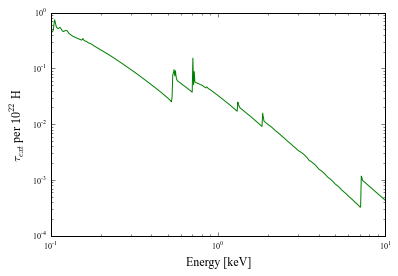

In [12]:
plt.plot( ENERGY, tau_ext, 'g-' )
plt.loglog()
plt.xlabel('Energy [keV]')
plt.ylabel(r'$\tau_{ext}$ per $10^{22}$ H')